In [46]:
import os

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import make_scorer, precision_score, confusion_matrix, ConfusionMatrixDisplay, get_scorer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC

In [47]:
os.environ['LOKY_MAX_CPU_COUNT'] = str(os.cpu_count()-1)  # To silence warning : Could not find the number of physical cores

In [48]:
randomState = 42

In [49]:
# Function to calculate weighted specificity
def multiclassSpecificity(yTrue, yPredict):
    cm = confusion_matrix(yTrue, yPredict)

    specificities = []
    for i in range(len(cm)):
        trueNegative = np.sum(cm) - np.sum(cm[i, :]) - np.sum(cm[:, i]) + cm[i, i]
        falsePositive = np.sum(cm[:, i]) - cm[i, i]
        specificity = trueNegative / (trueNegative + falsePositive) if (trueNegative + falsePositive) > 0 else 0
        specificities.append(specificity)

    return np.mean(specificities)

In [50]:
# Function to make pipeline
def makePipeline(modelToUsed):
    pipeline = Pipeline(steps=[
        ('feature_selection', SelectFromModel(
            estimator=RandomForestClassifier(random_state=randomState, n_jobs=-1),
            threshold='median')
         ),
        ('classifier', modelToUsed),
    ])
    return pipeline

#### Read data and define target

In [51]:
df = pd.read_csv('../Dataset/dataFrameProcessed')
targetCol = 'imdb_rating'

Split features and target data

In [52]:
X = df.drop(columns=[targetCol])
y = df[targetCol]

Built set of models selected

In [53]:
models = {
    'Support Vector Machine': SVC(kernel='rbf', random_state=randomState),
    'Random Forest'         : RandomForestClassifier(random_state=randomState),
    'Hist Gradient Boosting': HistGradientBoostingClassifier(random_state=randomState),
}

Built scoring metrix

In [54]:
scoringMetrix = {
    'accuracy'    : 'accuracy',
    'precision'   : make_scorer(precision_score, average='weighted', zero_division=1),
    'recall'      : 'recall_weighted',
    'f1'          : 'f1_weighted',
    'specificity' : make_scorer(multiclassSpecificity)
}

Split data (80:20)

In [55]:
XTrain, XTest, yTrain, yTest = train_test_split(X, y, test_size=0.2, random_state=randomState , stratify=y)

In [56]:
for name, model in models.items():
    pipeSC = makePipeline(model)
    pipeSC.fit(XTrain, yTrain)

    # Print model name and its results
    print(f'\n{name:<12}')
    for metricName, scorer in scoringMetrix.items():
        scorer = get_scorer(scorer)
        score = scorer(pipeSC, XTest, yTest)
        print(f"{metricName:<12}: {score:.5f}")


Support Vector Machine
accuracy    : 0.74500
precision   : 0.74503
recall      : 0.74500
f1          : 0.74055
specificity : 0.92204

Random Forest
accuracy    : 0.79600
precision   : 0.79994
recall      : 0.79600
f1          : 0.79357
specificity : 0.93443

Hist Gradient Boosting
accuracy    : 0.81400
precision   : 0.81630
recall      : 0.81400
f1          : 0.81331
specificity : 0.94160


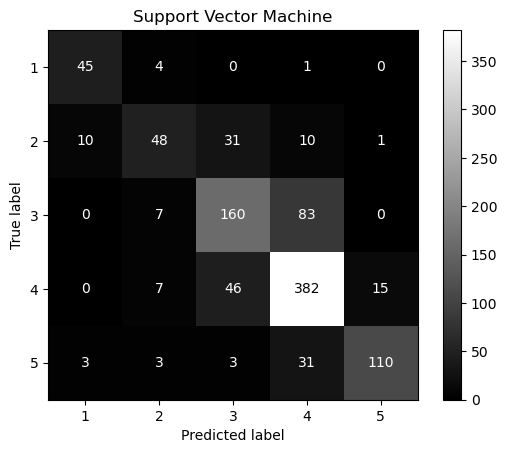

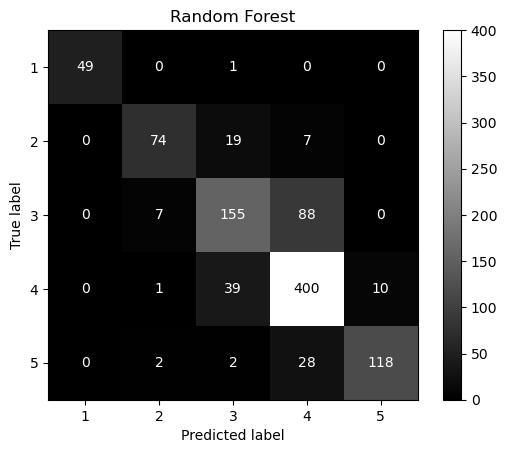

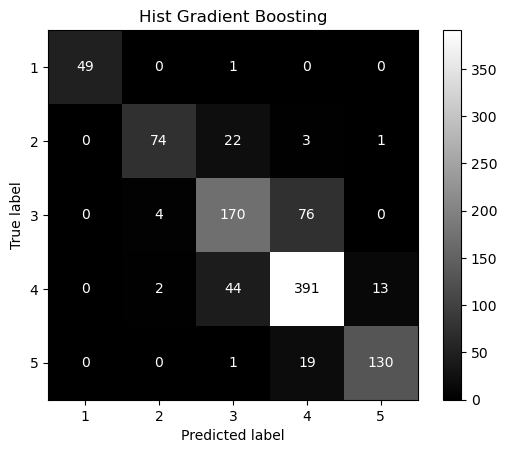

In [57]:
for name, model in models.items():
    # Fit pipeline
    pipeCM = makePipeline(model)
    pipeCM.fit(XTrain, yTrain)

    # Show confusion metrix
    dispCM = ConfusionMatrixDisplay.from_estimator(
        pipeCM,
        XTest,
        yTest,
        cmap='gist_gray',
    )
    dispCM.ax_.set_title(name)
    plt.show()